# logistic regression, knn, and svm models

In [68]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [69]:
X_train = pd.read_csv('data/X_train.csv', index_col='id')
X_test = pd.read_csv('data/X_test.csv', index_col='id')
y_train = pd.read_csv('data/y_train.csv', index_col='id')
y_test = pd.read_csv('data/y_test.csv', index_col='id')

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40095 entries, 58975 to 23269
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         40095 non-null  int64  
 1   installer          40095 non-null  object 
 2   longitude          40095 non-null  float64
 3   latitude           40095 non-null  float64
 4   num_private        40095 non-null  int64  
 5   basin              40095 non-null  object 
 6   region             40095 non-null  object 
 7   region_code        40095 non-null  int64  
 8   district_code      40095 non-null  int64  
 9   population         40095 non-null  int64  
 10  public_meeting     40095 non-null  object 
 11  scheme_management  40095 non-null  object 
 12  permit             40095 non-null  object 
 13  construction_year  40095 non-null  int64  
 14  extraction_type    40095 non-null  object 
 15  management         40095 non-null  object 
 16  payment           

In [71]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13365 entries, 33770 to 7443
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         13365 non-null  int64  
 1   installer          13365 non-null  object 
 2   longitude          13365 non-null  float64
 3   latitude           13365 non-null  float64
 4   num_private        13365 non-null  int64  
 5   basin              13365 non-null  object 
 6   region             13365 non-null  object 
 7   region_code        13365 non-null  int64  
 8   district_code      13365 non-null  int64  
 9   population         13365 non-null  int64  
 10  public_meeting     13365 non-null  object 
 11  scheme_management  13365 non-null  object 
 12  permit             13365 non-null  object 
 13  construction_year  13365 non-null  int64  
 14  extraction_type    13365 non-null  object 
 15  management         13365 non-null  object 
 16  payment            

In [72]:
y_train.value_counts(normalize=True)

status_group           
functional                 0.543609
non functional             0.383589
functional needs repair    0.072802
dtype: float64

In [73]:
y_test.value_counts(normalize=True)

status_group           
functional                 0.543659
non functional             0.383539
functional needs repair    0.072802
dtype: float64

*  the target is imbalanced, so we will be using SMOTE in the pipeline to resample the training data.

In [74]:
y_train = y_train.status_group

In [75]:
y_test = y_test.status_group

*  create a function to calculate log-loss.

In [2]:
# nice to have: putting all of your functions in a separate notebook
# include a description within each function, what the arguments take, what it returns, etc. 

In [76]:
def log_loss(model, X=X_train, y=y_train, scoring='neg_log_loss', cv=3):
    log_loss = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    log_loss = -log_loss.mean()
    print(f'Log loss: {log_loss}')

*  create a function to calculate model predictions for functional, needs-repair, and non-funcitonal wells.

In [77]:
def model_predictions(model, X=X_test, y=y_test):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
    print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
    print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

# logistic regression

*  we break up X_train into categorical and numerical variables, then use Pipelines and ColumnTransformer to OneHotEncode and scale the data. then we create an imbPipeline that takes the transformer, SMOTE, and the classifier.

In [78]:
X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64', 'int64'])

cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
num_pipe = Pipeline([('ss', StandardScaler())])

transformer = ColumnTransformer([('categorical', cat_pipe, X_train_cat.columns), 
                                  ('numerical', num_pipe, X_train_num.columns)])

In [11]:
logreg_pipe = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(n_jobs=-1, random_state=42))
])
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
 

In [12]:
print('Accuracy Score Train:', logreg_pipe.score(X_train,y_train))
print('Accuracy Score Test:', logreg_pipe.score(X_test,y_test))

Accuracy Score Train: 0.6367128070831775
Accuracy Score Test: 0.6333707444818556


In [13]:
log_loss(logreg_pipe, X_train, y_train)

Log loss: 0.8005327453806812


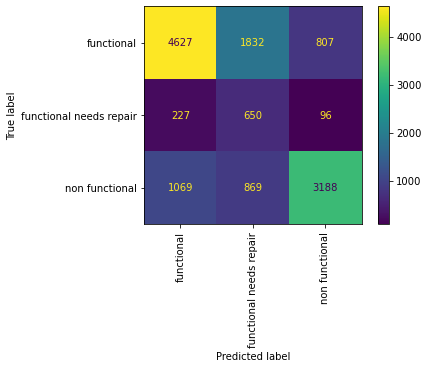

In [40]:
plot_confusion_matrix(logreg_pipe, X_test, y_test, xticks_rotation='vertical');

In [56]:
model_predictions(logreg_pipe, X_test, y_test)

The model correctly predicts 63.68% of the funtional wells.
The model correctly predicts 66.8% of the funtional-needs-repair wells.
The model correctly predicts 62.19% of the non-functional wells.


*  the model is not overfit, but probably underfit with an overall accuracy test score of 63.3%.  It predicts needs-repair wells at 66.8% and non-functional wells at 62.19% (for a combined 'score' of 128.99).

# logistic regression with grid search

*  we'll try a small grid search around the hyperparameter 'C'.

In [14]:
logreg_pipe_grid = {'logreg__C': [1e-2, 1, 1e2]}
gs_logreg_pipe = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_pipe_grid, cv=3)
gs_logreg_pipe.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('ss',
            

In [15]:
gs_logreg_pipe.best_params_

{'logreg__C': 1}

*  gridsearch suggest keeping the default regularization. let's move on to other models to check their scores.  we suspect they will perform better than logistic regression, so we'll verify that and then decide whether to do further tuning on the logistic regression model.

# knn (default parameters)

*  we move on to k nearest neighbors with the default hyperparameters.  

In [16]:
knn_pipe = imbPipeline([
    ('trans', transformer),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
 

In [17]:
print('Accuracy Score Train:', knn_pipe.score(X_train,y_train))
print('Accuracy Score Test:', knn_pipe.score(X_test,y_test))

Accuracy Score Train: 0.8260880409028557
Accuracy Score Test: 0.722484100261878


In [18]:
log_loss(knn_pipe, X_train, y_train)

Log loss: 3.7789466887696026


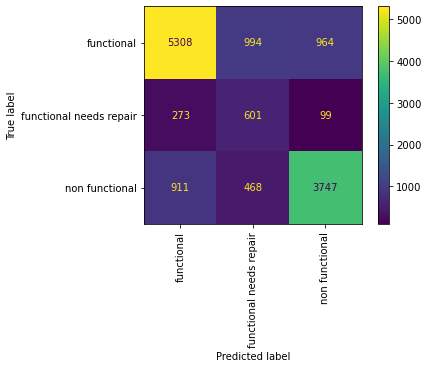

In [41]:
plot_confusion_matrix(knn_pipe, X_test, y_test, xticks_rotation='vertical');

In [58]:
model_predictions(knn_pipe, X_test, y_test)

The model correctly predicts 73.05% of the funtional wells.
The model correctly predicts 61.77% of the funtional-needs-repair wells.
The model correctly predicts 73.1% of the non-functional wells.


*  much better accuracy scores for the baseline knn model versus the logistic regression.  the model is overfitting, but the test accuracy score improves.  the only dowside is that it's slightly worse at predicting 'functional-needs-repair' wells.  the model predicts 61.77% of the needs-repair wells and 73.1% of the non-functional wells (for a combined 'score' of 134.87, much improved over the logistic regression model.)

*  let's try a grid search with knn.

# knn with gridsearch 

*  we'll search around the default n_neighbors=5, and search for three values of p.

In [24]:
knn_pipe_grid = {'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3]}
gs_knn_pipe = GridSearchCV(estimator=knn_pipe, param_grid=knn_pipe_grid, cv=2)
gs_knn_pipe.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('ss',
            

In [25]:
gs_knn_pipe.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1}

In [26]:
print('Accuracy Score Train:', gs_knn_pipe.score(X_train,y_train))
print('Accuracy Score Test:', gs_knn_pipe.score(X_test,y_test))

Accuracy Score Train: 0.8800349170719541
Accuracy Score Test: 0.7503928170594837


*  the grid search suggests using n_neighbors (3), and changing the p hyperparameter from the default (2) to 1.

# running knn again with new hyperparameters: n_neighbors=3, p=1

In [27]:
knn_pipe_after_gs = imbPipeline([
    ('trans', transformer),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=3, p=1, n_jobs=-1))
])
knn_pipe_after_gs.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
 

In [28]:
print('Accuracy Score Train:', knn_pipe_after_gs.score(X_train,y_train))
print('Accuracy Score Test:', knn_pipe_after_gs.score(X_test,y_test))

Accuracy Score Train: 0.8800349170719541
Accuracy Score Test: 0.7503928170594837


In [29]:
log_loss(knn_pipe_after_gs, X_train, y_train)

Log loss: 4.639916739202775


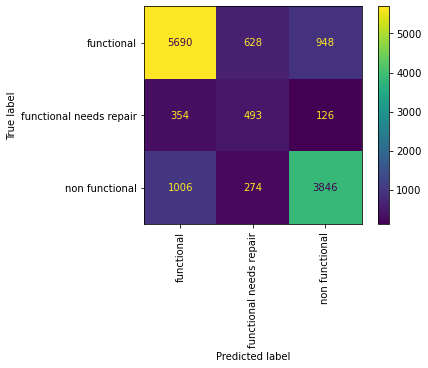

In [42]:
plot_confusion_matrix(knn_pipe_after_gs, X_test, y_test, xticks_rotation='vertical');

In [59]:
model_predictions(knn_pipe_after_gs, X_test, y_test)

The model correctly predicts 78.31% of the funtional wells.
The model correctly predicts 50.67% of the funtional-needs-repair wells.
The model correctly predicts 75.03% of the non-functional wells.


*  the tuning improves predictions of the functional and non-funtional wells, but does worse at predicting the 'functional-needs-repair' wells.  it predicts 50.67% of the needs-repair wells and 75.03% of the non-funtional wells (for a combined 'score' of 125.7, worse than the default, even though overall accuracy improves.)

*  let's move on and try support vector machines.

# support vector machines 

In [30]:
svm_pipe = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC())
])
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'num_private', 'region_code',
 

In [31]:
print('Accuracy Score Train:', svm_pipe.score(X_train,y_train))
print('Accuracy Score Test:', svm_pipe.score(X_test,y_test))

Accuracy Score Train: 0.7343309639605936
Accuracy Score Test: 0.7045267489711934


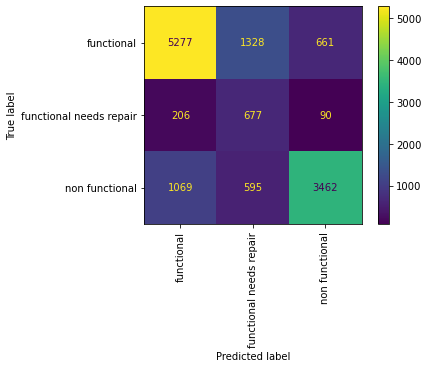

In [43]:
plot_confusion_matrix(svm_pipe, X_test, y_test, xticks_rotation='vertical');

In [60]:
model_predictions(svm_pipe, X_test, y_test)

The model correctly predicts 72.63% of the funtional wells.
The model correctly predicts 69.58% of the funtional-needs-repair wells.
The model correctly predicts 67.54% of the non-functional wells.


*  svm has lower overall accuracy scores, though it does do a better job at predicting 'functional-needs_repair' wells. it predicts 69.58% of the needs-repair wells and 67.54% of the non-functional wells (for a combined 'score' of 137.12, the best so far.)

# svm with gridsearch

In [80]:
svm_pipe_grid = {'svm__C': [.001, 1, 100, 1000], 'svm__gamma': [0.001, 1, 100]}
gs_svm_pipe = GridSearchCV(estimator=svm_pipe, param_grid=svm_pipe_grid, verbose=3, cv=2)
gs_svm_pipe.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] svm__C=0.001, svm__gamma=0.001 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... svm__C=0.001, svm__gamma=0.001, score=0.582, total= 9.3min
[CV] svm__C=0.001, svm__gamma=0.001 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.3min remaining:    0.0s


[CV] ...... svm__C=0.001, svm__gamma=0.001, score=0.585, total= 9.4min
[CV] svm__C=0.001, svm__gamma=1 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.7min remaining:    0.0s


[CV] .......... svm__C=0.001, svm__gamma=1, score=0.555, total=78.4min
[CV] svm__C=0.001, svm__gamma=1 ......................................
[CV] ......... svm__C=0.001, svm__gamma=1, score=0.574, total=297.7min
[CV] svm__C=0.001, svm__gamma=100 ....................................
[CV] ....... svm__C=0.001, svm__gamma=100, score=0.548, total=366.3min
[CV] svm__C=0.001, svm__gamma=100 ....................................
[CV] ........ svm__C=0.001, svm__gamma=100, score=0.551, total= 7.4min
[CV] svm__C=1, svm__gamma=0.001 ......................................
[CV] .......... svm__C=1, svm__gamma=0.001, score=0.621, total= 6.5min
[CV] svm__C=1, svm__gamma=0.001 ......................................
[CV] .......... svm__C=1, svm__gamma=0.001, score=0.620, total= 6.3min
[CV] svm__C=1, svm__gamma=1 ..........................................
[CV] .............. svm__C=1, svm__gamma=1, score=0.717, total=13.6min
[CV] svm__C=1, svm__gamma=1 ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 1046.2min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('ss',
            

In [81]:
gs_svm_pipe.best_params_

{'svm__C': 100, 'svm__gamma': 1}

gridsearch suggests C=100 and gamma=1.

In [82]:
print('Accuracy Score Train:', gs_svm_pipe.score(X_train,y_train))
print('Accuracy Score Test:', gs_svm_pipe.score(X_test,y_test))

Accuracy Score Train: 0.8884898366379848
Accuracy Score Test: 0.7414141414141414


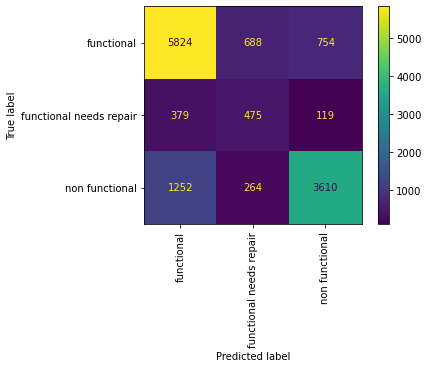

In [86]:
plot_confusion_matrix(gs_svm_pipe, X_test, y_test, xticks_rotation='vertical');

In [85]:
model_predictions(gs_svm_pipe, X_test, y_test)

The model correctly predicts 80.15% of the funtional wells.
The model correctly predicts 48.82% of the funtional-needs-repair wells.
The model correctly predicts 70.43% of the non-functional wells.


*  while the overall accuracy improves on the tuned model, the predictions for needs-repair drops considerably.  this model predicts needs-repair wells 48.82% of the time, and non-functional wells 70.43% of the time (for a combined score of 119.2, considerable worse than the default svc model).  